Otsu's threshold value: 123
[(213, 5, 152), (188, 99, 138), (223, 82, 191), (63, 221, 133), (89, 95, 181), (46, 211, 85), (75, 105, 39), (97, 174, 164), (12, 234, 173), (13, 212, 1), (3, 83, 91), (146, 50, 212), (54, 93, 192), (119, 168, 20), (118, 61, 255), (110, 95, 131)]


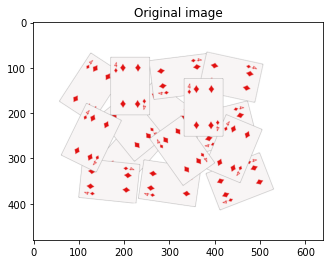

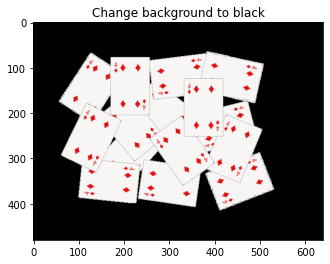

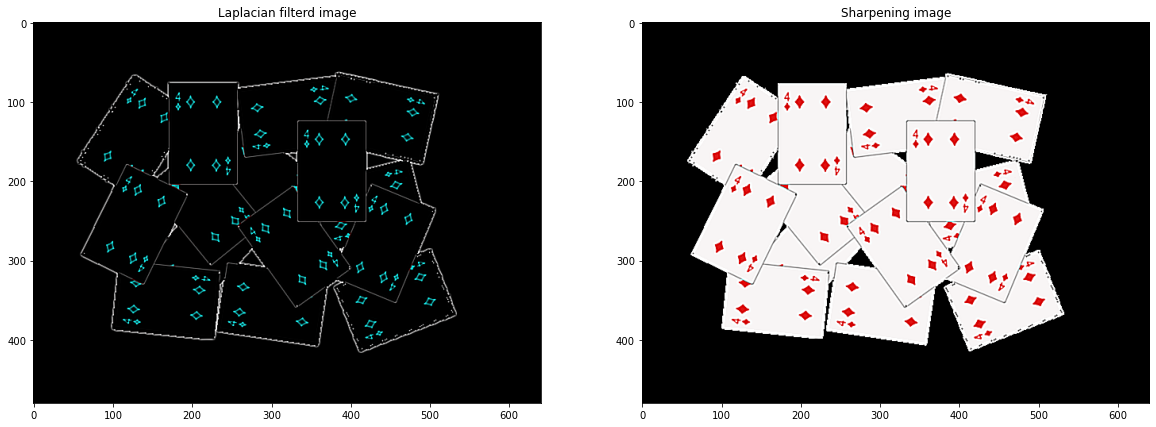

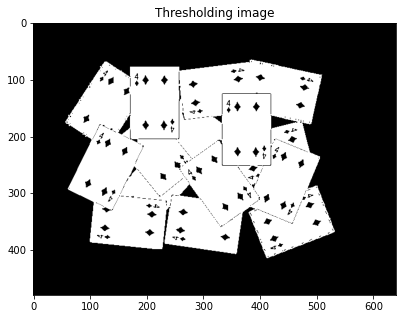

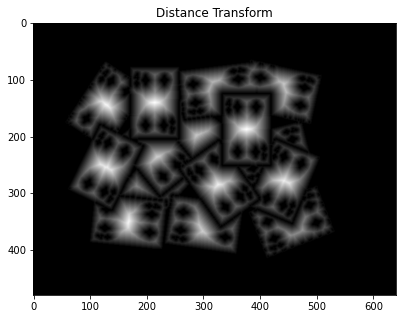

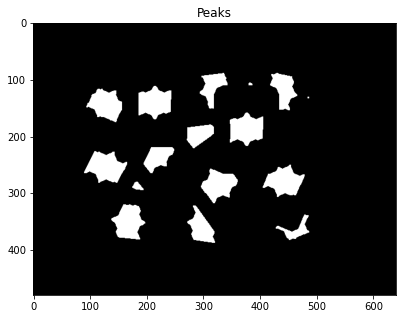

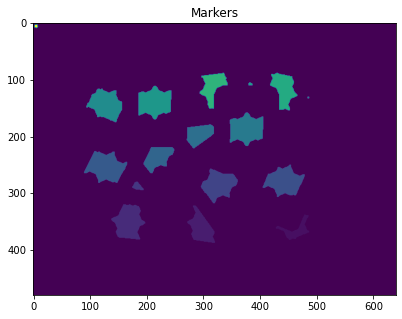

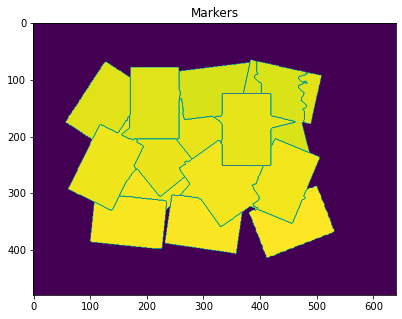

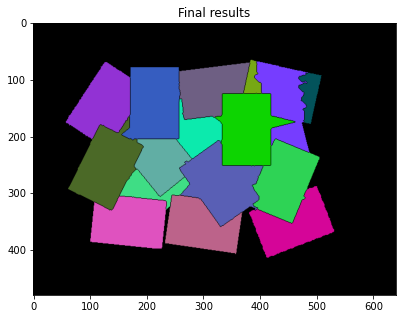

In [92]:
import numpy as np
import cv2
import mahotas
from matplotlib import pyplot as plt
import random

random.seed(12345)

#Open source image
path = r'../images/cards.png'
original = cv2.imread(path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

#Show source image
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('Original image')
ax1.imshow(original)

#Fill black (0) to background of image (background is white (255,255,255))
original[np.all(original == 255, axis=2)] = 0

fig2 = plt.figure()
ax1 = fig2.add_subplot(1,1,1)
ax1.set_title('Change background to black')
ax1.imshow(original)

#Laplacian operator 1st method
original = cv2.GaussianBlur(original, (3, 3), 0) #optional to filter noise
#imgLaplacian = cv2.Laplacian(original, cv2.CV_64F, ksize=3)
#sharp = np.float64(original)
#imgResult = sharp - imgLaplacian
#imgLaplacian = cv2.convertScaleAbs(imgLaplacian)
#imgResult = cv2.convertScaleAbs(imgResult)

#Laplacian operator 2nd method
#imgLaplacian = cv2.Laplacian(original, cv2.CV_64F, 3)
#sharp = np.float64(original)
#imgResult = sharp - imgLaplacian
#imgLaplacian = np.uint8(np.absolute(imgLaplacian))
#imgResult = np.uint8(np.absolute(imgResult))

#Laplacian operator 3rd method
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float64)
imgLaplacian = cv2.filter2D(original, cv2.CV_64F, kernel)
sharp = np.float64(original)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
#imgResult = imgResult.astype('uint8')
imgResult = np.uint8(imgResult)
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

fig3 = plt.figure(figsize=(20, 14))
ax1 = fig3.add_subplot(1,2,1)
ax1.set_title('Laplacian filterd image')
ax1.imshow(imgLaplacian)
ax2 = fig3.add_subplot(1,2,2)
ax2.set_title('Sharpening image')
ax2.imshow(imgResult)

#convert to gray scale
bw = cv2.cvtColor(imgResult, cv2.COLOR_RGB2GRAY)

#Perform Otsu Thresholding
#T, threshold = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
T = mahotas.thresholding.otsu(bw)
print("Otsu's threshold value: {}".format(T))
bw[bw > T] = 255
bw[bw < 255] = 0
#bw = cv2.bitwise_not(bw)

fig4 = plt.figure(figsize=(12, 5))
ax1 = fig4.add_subplot(1,1,1)
ax1.set_title('Thresholding image')
ax1.imshow(bw, cmap='gray')

#Perform Distance Transform
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
fig5 = plt.figure(figsize=(12, 5))
ax1 = fig5.add_subplot(1,1,1)
ax1.set_title('Distance Transform')
ax1.imshow(dist, cmap='gray')

#Perform 2nd round Binary Thresholding
T, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)

# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)

fig6 = plt.figure(figsize=(12, 5))
ax1 = fig6.add_subplot(1,1,1)
ax1.set_title('Peaks')
ax1.imshow(dist, cmap='gray')

#dist_8u = dist.astype('uint8')
dist_8u = np.uint8(dist)

# Find total markers
(contours, _) = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)

# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)

# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')

fig7 = plt.figure(figsize=(12, 5))
ax1 = fig7.add_subplot(1,1,1)
ax1.set_title('Markers')
ax1.imshow(markers_8u)

cv2.watershed(imgResult, markers)

mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)

fig8 = plt.figure(figsize=(12, 5))
ax1 = fig8.add_subplot(1,1,1)
ax1.set_title('Markers')
ax1.imshow(mark)

# Generate random colors
colors = []
for contour in contours:
    colors.append((random.randint(0,256), random.randint(0,256), random.randint(0,256)))
    
print(colors)

# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)

# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

fig9 = plt.figure(figsize=(12, 5))
ax1 = fig9.add_subplot(1,1,1)
ax1.set_title('Final results')
ax1.imshow(dst)